In [17]:
import os


In [18]:
import torch


In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

In [38]:
import torchvision
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Normalize
import torchvision.models as models
from torchvision import transforms
from xgboost import XGBClassifier

In [21]:
cwd = os.getcwd()
root = cwd+'/data/Garbage_Classification'
height = 16
width = 16
transformations = transforms.Compose([transforms.Resize((height, width)), 
                                      transforms.ToTensor(), 
                                      Normalize((0.5,), (0.5,))])
dataset = ImageFolder(root, transform = transformations)

In [22]:
def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label], label))
    plt.imshow(img.permute(1, 2, 0))
    plt.xticks(())
    plt.yticks(())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: plastic (4)


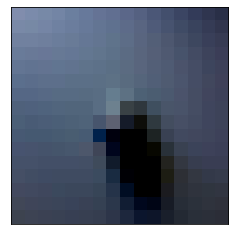

In [23]:
img, label = dataset[2000]
show_example(img, label)

In [24]:
print(dataset[0][0])

tensor([[[ 0.8824,  0.8275,  0.8431,  0.8275,  0.8039,  0.8039,  0.7804,
           0.7490,  0.7333,  0.7176,  0.6706,  0.6863,  0.7176,  0.6941,
           0.6627,  0.6627],
         [ 0.8824,  0.8196,  0.8118,  0.8039,  0.8039,  0.7961,  0.7804,
           0.7490,  0.7255,  0.6235,  0.6000,  0.6471,  0.6784,  0.6549,
           0.6314,  0.6235],
         [ 0.8667,  0.7961,  0.7961,  0.7961,  0.7961,  0.7882,  0.7725,
           0.7333,  0.6863,  0.6314,  0.5922,  0.5922,  0.6392,  0.6235,
           0.6078,  0.5765],
         [ 0.8353,  0.7647,  0.7882,  0.7882,  0.7882,  0.7725,  0.7490,
           0.7333,  0.6392,  0.6471,  0.6078,  0.5843,  0.6235,  0.5843,
           0.5529,  0.5608],
         [ 0.8118,  0.7490,  0.7804,  0.7725,  0.7725,  0.7647,  0.7333,
           0.7176,  0.6784,  0.6157,  0.6157,  0.6078,  0.6000,  0.5529,
           0.5216,  0.5216],
         [ 0.7961,  0.7490,  0.7725,  0.7725,  0.7569,  0.7490,  0.7176,
           0.7020,  0.6784,  0.6549,  0.6078,  0.576

In [25]:
def split_indices(n, test_frac, val_frac, seed):
    # Determine the size of the validation set and the test set
    n_test = int(test_frac * n)
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[:n_test], idxs[n_test:n_test+n_val], idxs[n_test+n_val:]

In [26]:
test_frac = 0.1 # Set the fraction for the test set
val_frac =  0.1 ## Set the fraction for the validation set
rand_seed =  42 ## Set the random seed
test_indices, val_indices, train_indices = split_indices(len(dataset), test_frac, val_frac, rand_seed)
print("#samples in training set: {}".format(len(train_indices)))
print("#samples in validation set: {}".format(len(val_indices)))
print("#samples in test set: {}".format(len(test_indices)))

#samples in training set: 2023
#samples in validation set: 252
#samples in test set: 252


In [27]:
batch_size = 8
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                    batch_size,
                    sampler=val_sampler)

In [28]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


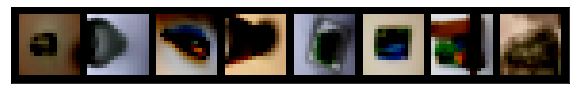

In [29]:
show_batch(train_dl)

In [30]:
class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [31]:
model = ResNet()

In [32]:
def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [33]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [34]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    models = []
    ######################
    #   YOUR CODE HERE   #
    ######################
    for epoch in range(n_epochs):
        optimization = opt_fn(model.parameters(), lr = lr)
        train_loss = 0
        train_accuracy = None
        preds, keys = [], []
        for images, labels in train_dl:
            # Model output
            optimization.zero_grad()
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimization.step()
            
            train_loss += loss.item()
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            keys.extend(labels)          
            
        preds, keys = torch.tensor(preds), torch.tensor(keys)
        train_accuracy = torch.sum(preds == keys).item() / len(preds)
        train_loss /= len(preds)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
    # Validation process
        val_loss = 0
        val_accuracy = None
        if len(val_dl) > 0:
            with torch.no_grad():
                preds, keys = [], []
                for images, labels in val_dl:
                # Model output
                    y_pred = model(images)
                    loss = loss_fn(y_pred, labels)
                    val_loss += loss.item()
                    _, y_pred = torch.max(y_pred, dim=1)
                    preds.extend(y_pred)
                    keys.extend(labels)               
            preds, keys = torch.tensor(preds), torch.tensor(keys)
            val_accuracy = torch.sum(preds == keys).item() / len(preds)
            models.append(model)
            val_loss /= len(preds)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            
    # Print progress
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.4f}, val_loss: {:.4f}, train_accuracy: {:.4f}, val_accuracy: {:.4f}"
                    .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.4f}, train_accuracy: {:.4f}"
                    .format(epoch+1, n_epochs, train_loss, train_accuracy))
    if val_accuracy is not None:
        model = models[np.argmax(val_accuracies)]
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [37]:
def evaluate(model, test_dl):
    with torch.no_grad():
        model.eval()
        total_test_dl = 0
        preds, labels = [], []
        for xb, yb in test_dl:
            # Model output
            y_pred = model(xb)
            _, y_pred = torch.max(y_pred, dim=1)
            preds.extend(y_pred)
            labels.extend(yb)               
            total_test_dl += len(yb)

    preds, labels = torch.tensor(preds), torch.tensor(labels)
    test_accuracy = torch.sum(preds == labels).item() / len(preds)
    return test_accuracy

In [35]:
from torch.optim import Adam
num_epochs = 10# Max number of training epochs
loss_fn = nn.CrossEntropyLoss()# Define the loss function
opt_fn = Adam# Select an optimizer
lr = 0.001# Set the learning rate

In [52]:
path = [root+'/cardboard', root+'/glass', root+'/metal', root+'/paper', root+'/plastic', root+'/trash']
images = []
labels = []
for i in range(6):
    for filename in sorted(os.listdir(path[i])):
        image = np.asarray(Image.open(path[i] + "/" + filename))
        height, width = image.shape[0], image.shape[1]
        image = image.flatten()
        images.append(image)
        labels.append(i)
images = np.array(images)
labels = np.array(labels)
X = pd.DataFrame(data=images)
y = pd.DataFrame(data=labels)

test_indices, val_indices, train_indices = split_indices(len(dataset), 0.1, 0.1, 42)

X_train, X_val, X_test = X.iloc[train_indices], X.iloc[val_indices], X.iloc[test_indices]
y_train, y_val, y_test = y.iloc[train_indices].values.ravel(), y.iloc[val_indices].values.ravel(), y.iloc[test_indices].values.ravel()

subset_indices, _ , _ = split_indices(len(dataset), 0.1, 0, 10)
X_sub = X.iloc[subset_indices]
y_sub = y.iloc[subset_indices].values.ravel()

print(y_train)

[2 3 0 ... 2 2 1]


In [ ]:
from sklearn.model_selection import StratifiedKFold
subset_train_indices, subset_test_indices, _ = split_indices(len(dataset), 0.09, 0.01, 10)
subset_sampler = SubsetRandomSampler(subset_train_indices)
test_sampler = SubsetRandomSampler(subset_test_indices)
batch_sizes = [10,20,40,60,80,100]
epochs = [10,50,100]
learning_rate = [0.1,0.01,0.001]
acc = []
for batch in batch_sizes:
    for epoch in epochs:
        for lr in learning_rate:
            skf = StratifiedKFold(n_splits = 5, shuffle = True)
            subset_dl = DataLoader(dataset, batch, sampler=subset_sampler)
            model = ResNet()
            history = train_model(epoch, model, subset_dl, [], loss_fn, opt_fn, lr)
            model = history[0]
            test_dl = DataLoader(dataset, batch, sampler=test_sampler)
            acc.append(evaluate(model,test_dl))
            print(evaluate(model,test_dl))
            
idx = acc.index(max(acc))
batch_size = batch_sizes[idx//(len(epochs)*len(learning_rate))]
num_epochs = epochs[(idx%(len(epochs)*len(learning_rate)))//len(learning_rate)]
lr = learning_rate[(idx%(len(epochs)*len(learning_rate)))%len(learning_rate)]

In [20]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

Epoch 1/10, train_loss: 0.2135, val_loss: 0.2196, train_accuracy: 0.2397, val_accuracy: 0.2381
Epoch 2/10, train_loss: 0.2195, val_loss: 0.2214, train_accuracy: 0.2274, val_accuracy: 0.2222
Epoch 3/10, train_loss: 0.2165, val_loss: 0.2111, train_accuracy: 0.2378, val_accuracy: 0.2619
Epoch 4/10, train_loss: 0.2133, val_loss: 0.2154, train_accuracy: 0.2501, val_accuracy: 0.1746
Epoch 5/10, train_loss: 0.2115, val_loss: 0.2117, train_accuracy: 0.2551, val_accuracy: 0.2738
Epoch 6/10, train_loss: 0.2097, val_loss: 0.2142, train_accuracy: 0.2961, val_accuracy: 0.2976
Epoch 7/10, train_loss: 0.2107, val_loss: 0.2159, train_accuracy: 0.2966, val_accuracy: 0.2619
Epoch 8/10, train_loss: 0.2106, val_loss: 0.2146, train_accuracy: 0.2704, val_accuracy: 0.2500
Epoch 9/10, train_loss: 0.2084, val_loss: 0.2134, train_accuracy: 0.2758, val_accuracy: 0.1905
Epoch 10/10, train_loss: 0.2088, val_loss: 0.2150, train_accuracy: 0.2635, val_accuracy: 0.2222


In [21]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

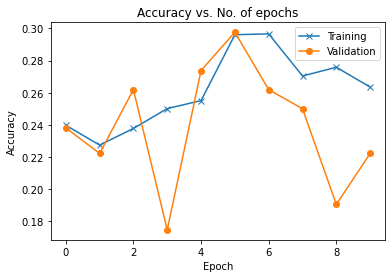

In [22]:
plot_accuracy(train_accuracies, val_accuracies)

In [23]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

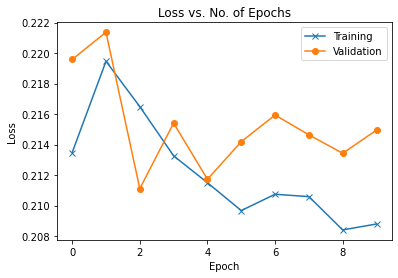

In [24]:
plot_losses(train_losses, val_losses)

In [29]:
train_indices = np.append(train_indices, val_indices)
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)

[1124 1387  157 ... 1130 1294  860]
[1124 1387  157 ... 1546   76  432]


In [31]:
num_epochs = 20# Max number of training epochs
lr = 0.001# Set the learning rate

history = train_model(num_epochs, model, train_dl, [], loss_fn, opt_fn, lr)
model = history[0]

Epoch 1/20, train_loss: 0.2081, train_accuracy: 0.3178
Epoch 2/20, train_loss: 0.2019, train_accuracy: 0.3569
Epoch 3/20, train_loss: 0.2033, train_accuracy: 0.3591
Epoch 4/20, train_loss: 0.2091, train_accuracy: 0.3200
Epoch 5/20, train_loss: 0.2080, train_accuracy: 0.3209
Epoch 6/20, train_loss: 0.2059, train_accuracy: 0.3349
Epoch 7/20, train_loss: 0.2034, train_accuracy: 0.3284
Epoch 8/20, train_loss: 0.2002, train_accuracy: 0.3780
Epoch 9/20, train_loss: 0.1962, train_accuracy: 0.4101
Epoch 10/20, train_loss: 0.1986, train_accuracy: 0.4141
Epoch 11/20, train_loss: 0.1996, train_accuracy: 0.4057
Epoch 12/20, train_loss: 0.1941, train_accuracy: 0.4277
Epoch 13/20, train_loss: 0.1967, train_accuracy: 0.4101
Epoch 14/20, train_loss: 0.1957, train_accuracy: 0.4295
Epoch 15/20, train_loss: 0.1950, train_accuracy: 0.4391
Epoch 16/20, train_loss: 0.1935, train_accuracy: 0.4558
Epoch 17/20, train_loss: 0.1941, train_accuracy: 0.4782
Epoch 18/20, train_loss: 0.1923, train_accuracy: 0.4804
E

In [32]:
num_epochs = 20
lr = 0.0001
history = train_model(num_epochs, model, train_dl, [], loss_fn, opt_fn, lr)
model = history[0]

Epoch 1/20, train_loss: 0.1889, train_accuracy: 0.5134
Epoch 2/20, train_loss: 0.1888, train_accuracy: 0.5081
Epoch 3/20, train_loss: 0.1887, train_accuracy: 0.5169
Epoch 4/20, train_loss: 0.1871, train_accuracy: 0.5323
Epoch 5/20, train_loss: 0.1873, train_accuracy: 0.5222
Epoch 6/20, train_loss: 0.1869, train_accuracy: 0.5222
Epoch 7/20, train_loss: 0.1869, train_accuracy: 0.5270
Epoch 8/20, train_loss: 0.1874, train_accuracy: 0.5196
Epoch 9/20, train_loss: 0.1857, train_accuracy: 0.5156
Epoch 10/20, train_loss: 0.1871, train_accuracy: 0.5235
Epoch 11/20, train_loss: 0.1859, train_accuracy: 0.5354
Epoch 12/20, train_loss: 0.1860, train_accuracy: 0.5376
Epoch 13/20, train_loss: 0.1855, train_accuracy: 0.5371
Epoch 14/20, train_loss: 0.1851, train_accuracy: 0.5402
Epoch 15/20, train_loss: 0.1844, train_accuracy: 0.5473
Epoch 16/20, train_loss: 0.1843, train_accuracy: 0.5411
Epoch 17/20, train_loss: 0.1853, train_accuracy: 0.5376
Epoch 18/20, train_loss: 0.1846, train_accuracy: 0.5516
E

In [35]:
def view_prediction(img, label, probs, classes):
    """
    Visualize predictions.
    """
    probs = probs.cpu().numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(8,15), ncols=2)
    ax1.imshow(img.permute(1,2,0))
    ax1.axis('off')
    ax1.set_title('Actual: {}'.format(classes[label]))
    ax2.barh(np.arange(6), probs)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(6))
    ax2.set_yticklabels(classes, size='small');
    ax2.set_title('Predicted: probabilities')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


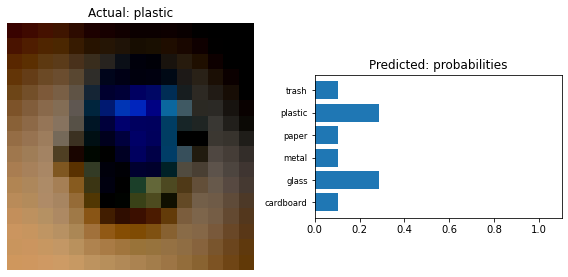

In [36]:
images = iter(train_dl)
for imgs, labels in images:
    with torch.no_grad():
        model.eval()
        # Calculate the class probabilites (log softmax) for img
        probs = torch.nn.functional.softmax(model(imgs[0].unsqueeze(0)), dim=1)
        # Plot the image and probabilites
        view_prediction(imgs[0], labels[0], probs, dataset.classes)
    break

In [38]:
test_sampler = SubsetRandomSampler(test_indices)
test_dl = DataLoader(dataset,
                      batch_size,
                      sampler=test_sampler)
test_dl = DeviceDataLoader(test_dl, device)

In [40]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.5992


In [13]:
from sklearn.model_selection import GridSearchCV
estimator = XGBClassifier(
    objective= 'multi:softprob',
    num_class= 6
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'accuracy',
    n_jobs = 10,
    cv = 10,
)

grid_search.fit(X_sub, y_sub)
grid_search.best_estimator_
os.environ['KMP_DUPLICATE_LIB_OK']='True'
xgbmodel = grid_search.best_estimator_
xgbmodel.fit(X_train, y_train)
xgbmodel.score(X_val, y_val)

/Users/quanlin/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:52:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.6944444444444444

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.43253968253968256


In [15]:
print("Accuracy:", xgbmodel.score(X_test, y_test))

Accuracy: 0.6825396825396826


In [58]:
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression(max_iter = 1e5)
parameters = {
    'C': [0.001,0.01,0.1,1,10,100,1000],
    'penalty': ['l1','l2']
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters, 
    n_jobs = 10,
    cv = 10,
)
grid_search.fit(X_sub, y_sub)
lr = grid_search.best_estimator_
lr = lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.44444444444444444
